In [1]:
import glob
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [3]:
# Setup your PBSCluster
import dask
from dask.distributed import Client
from dask_jobqueue import PBSCluster

ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35808 instead
  f"Port {expected} is already in use.\n"


In [4]:
client.cluster

### Some custom functions

In [5]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [6]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [7]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]  
    
    return ds

In [8]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg

In [9]:
whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb

In [10]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

### Start here
 - load and examine the ensemble

In [11]:
%%time
dvs = ['TLAI','TBOT','RAIN','NPP','EFLX_LH_TOT','TWS']
ds = get_ds(dvs,'h0',1850,2014)

CPU times: user 4min 7s, sys: 11.3 s, total: 4min 18s
Wall time: 8min 29s


# explore global mean LAI 

In [12]:
lai_gm = gmean(ds.TLAI,ds.la).compute()

Text(0, 0.5, 'global mean LAI - defaultCLM')

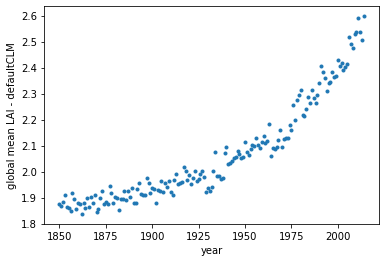

In [13]:
lai_gm_peak = lai_gm.groupby('time.year').max()
lai_gm_peak[0,:].plot.line('.')
plt.ylabel('global mean LAI - defaultCLM')

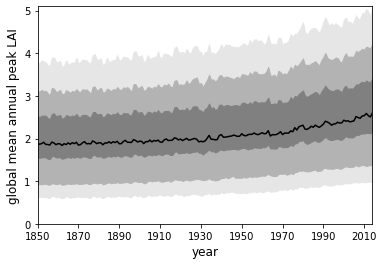

In [20]:
t=1850+np.arange(165)

qs=[1,5,25]
cs=[0.9,0.7,0.5]
for q,c in zip(qs,cs):
    q1 = lai_gm_peak.quantile(q/100,dim='ens')
    q2 = lai_gm_peak.quantile(1-q/100,dim='ens')
    plt.fill_between(t,q1,q2,color=c*np.ones(3),label=q)
plt.plot(t,lai_gm_peak[0,:],c='k')
plt.xlim([1850,2014])
plt.ylim([0,5.1])

#plt.plot(t,np.zeros(165),'k:')
plt.xlabel('year',fontsize=12)
plt.xticks(1850+20*np.arange(9))
plt.ylabel('global mean annual peak LAI',fontsize=12)
plt.savefig('../figs/lai_exploration/lai_annual_peak_ensemble_1850-2014.png',dpi=300)

# explore default at one gridcell

In [13]:
ds_def_100 = ds.TLAI[0,:,100].compute()

In [14]:
peak = ds_def_100.groupby('time.year').max()
amp = peak - ds_def_100.groupby('time.year').min()

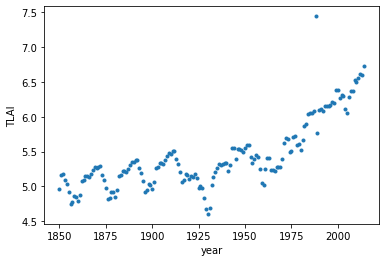

In [15]:
peak.plot.line('.')

In [16]:
# explore ensemble at one gridcell
ds_200 = ds.TLAI[:,:,200].compute() # one grid cell

In [17]:
peak = ds_200.groupby('time.year').max()
amp = peak - ds_200.groupby('time.year').min()

In [18]:
peak2014 = peak.isel(year=9).compute() # 2014 only

In [21]:
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)

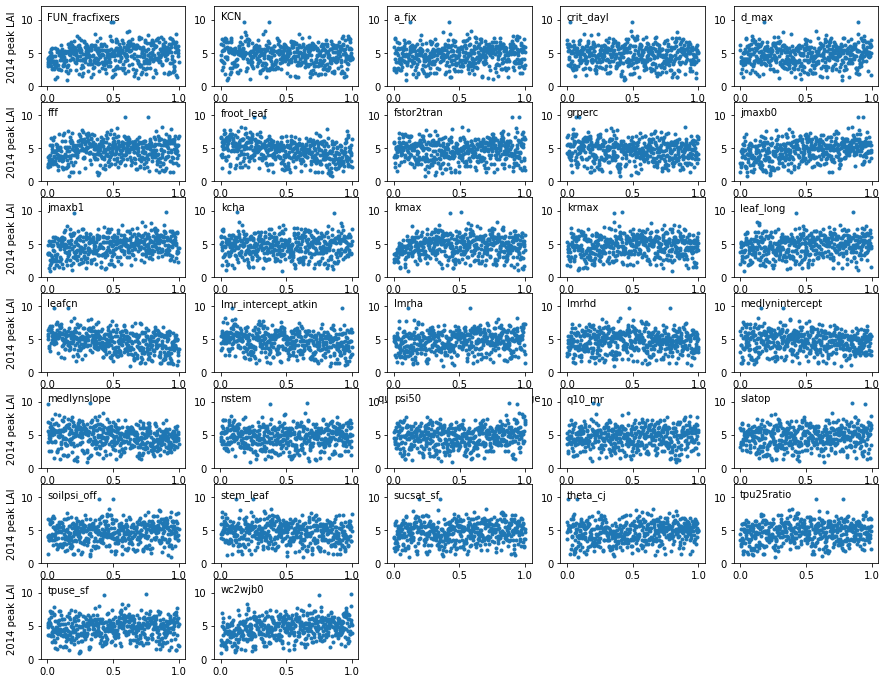

In [28]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],peak2014[1:],'.')
    plt.ylim([0,12])
    plt.text(0,10,p)
    if i%5==0:
        plt.ylabel('2014 peak LAI')
    if i==17:
        plt.xlabel('quantile within parameter range')

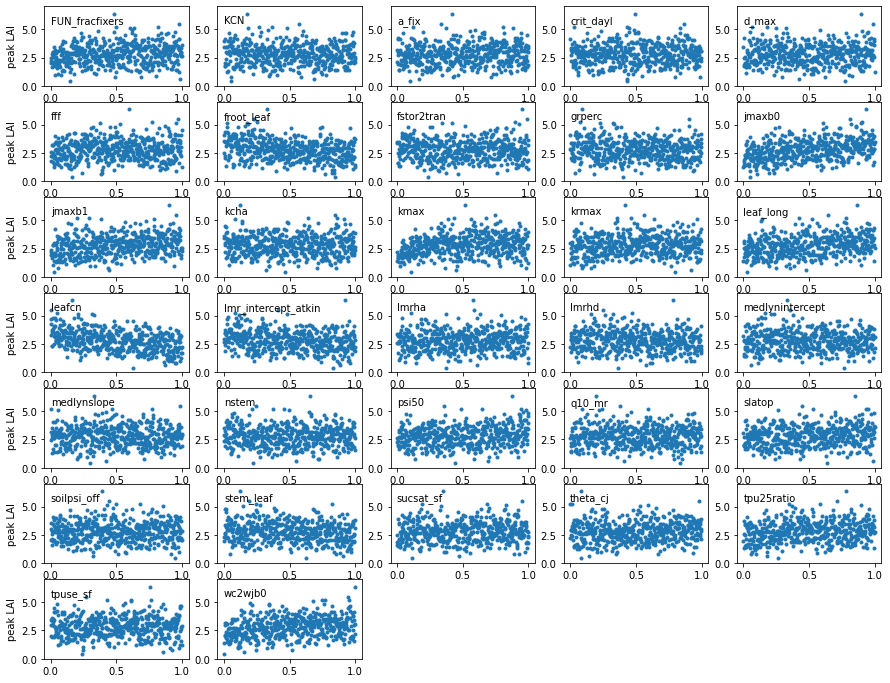

In [24]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],lai_gm_peak[1:,-1],'.')
    plt.ylim([0,7])
    plt.text(0,5.5,p)
    if i%5==0:
        plt.ylabel('peak LAI')
    if i==32:
        plt.xlabel('quantile within parameter range')
plt.savefig('../figs/lai_exploration/lai_GM_peak_2014_parameter_scatter.png',dpi=300)

In [25]:
present=gmean(ds.TLAI.sel(time=slice('2005','2014')).mean(dim='time'),ds.la)
past = gmean(ds.TLAI.sel(time=slice('1850','1859')).mean(dim='time'),ds.la)

In [26]:
deltaLAI = present-past
np.shape(deltaLAI)

(501,)

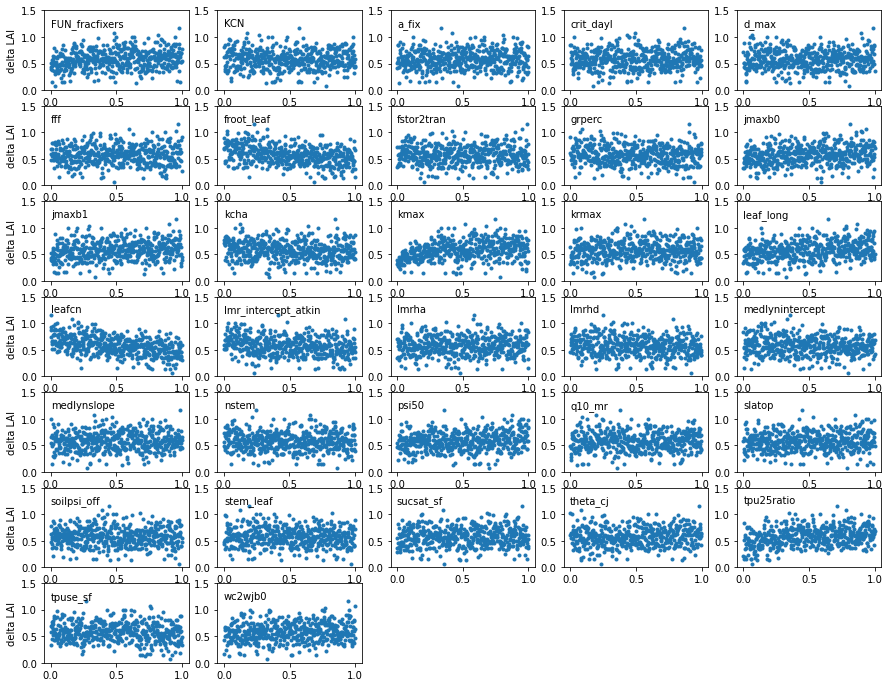

In [27]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],deltaLAI[1:],'.')
    plt.ylim([0,1.5])
    plt.text(0,1.2,p)
    if i%5==0:
        plt.ylabel('delta LAI')
    if i==32:
        plt.xlabel('quantile within parameter range')
plt.savefig('../figs/lai_exploration/lai_GM_peak_delta_(2005-2014)-(1850-1859)_parameter_scatter.png',dpi=300)

Biome level analysis

In [29]:
da=amean(ds.TLAI.sel(ens=0)).max(dim='year').compute()
xbmax=bmean(da,ds.la)

tdef=ds.TLAI.isel(ens=0)
tamp=(tdef.groupby('time.year').max()-tdef.groupby('time.year').min()).mean(dim='year').compute()
xbamp=bmean(tamp,ds.la)

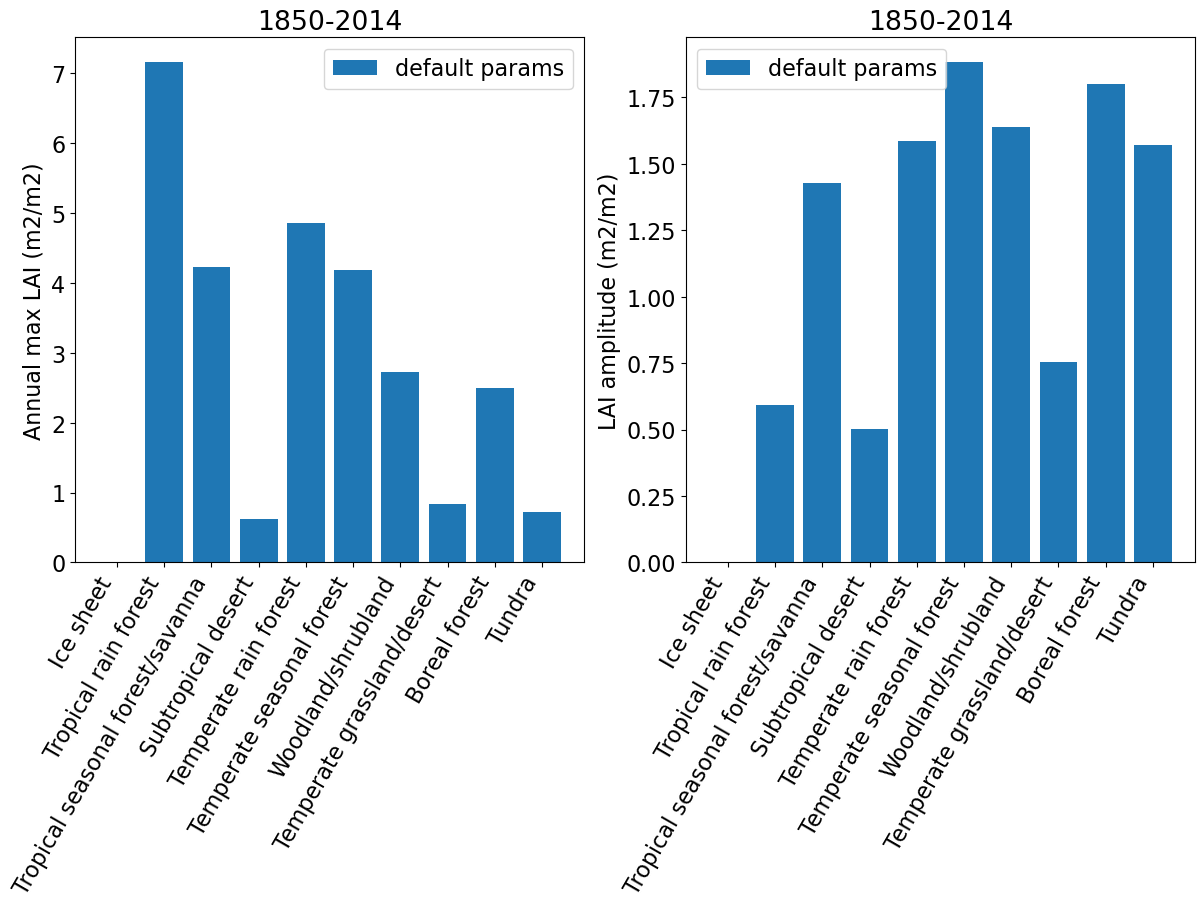

In [34]:
plt.figure(num=None, figsize=(14, 7), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.2, hspace=0.4)
plt.rcParams.update({'font.size': 16})

plt.subplot(1,2,1)
plt.bar(range(10),xbmax,label='default params')
plt.xticks(range(10),xbmax.biome_name.values,rotation=60,ha='right')
plt.ylabel('Annual max LAI (m2/m2)')
plt.title('1850-2014')
plt.legend();

plt.subplot(1,2,2)
plt.bar(range(10),xbamp,label='default params')
plt.xticks(range(10),xbamp.biome_name.values,rotation=60,ha='right')
plt.ylabel('LAI amplitude (m2/m2)')
plt.title('1850-2014')
plt.legend();

plt.savefig('../figs/lai_exploration/biome_LAI_peak+amp_1850-2014_CLMdefault.png',dpi=100)

In [35]:
x=ds.TLAI.isel(ens=0).groupby('time.month').mean()
xb=bmean(x,ds.la)

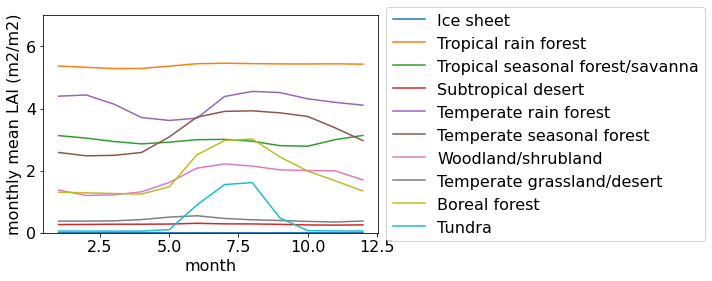

In [38]:
for bb in range(len(xbmax)):
    xb.sel(biome=bb).plot(label=xb[bb].biome_name.values)
    plt.ylim([0,7])
    plt.ylabel('monthly mean LAI (m2/m2)');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('')
plt.savefig('../figs/lai_exploration/biome_seasonal_cycle_1850-2014.png',dpi=100)

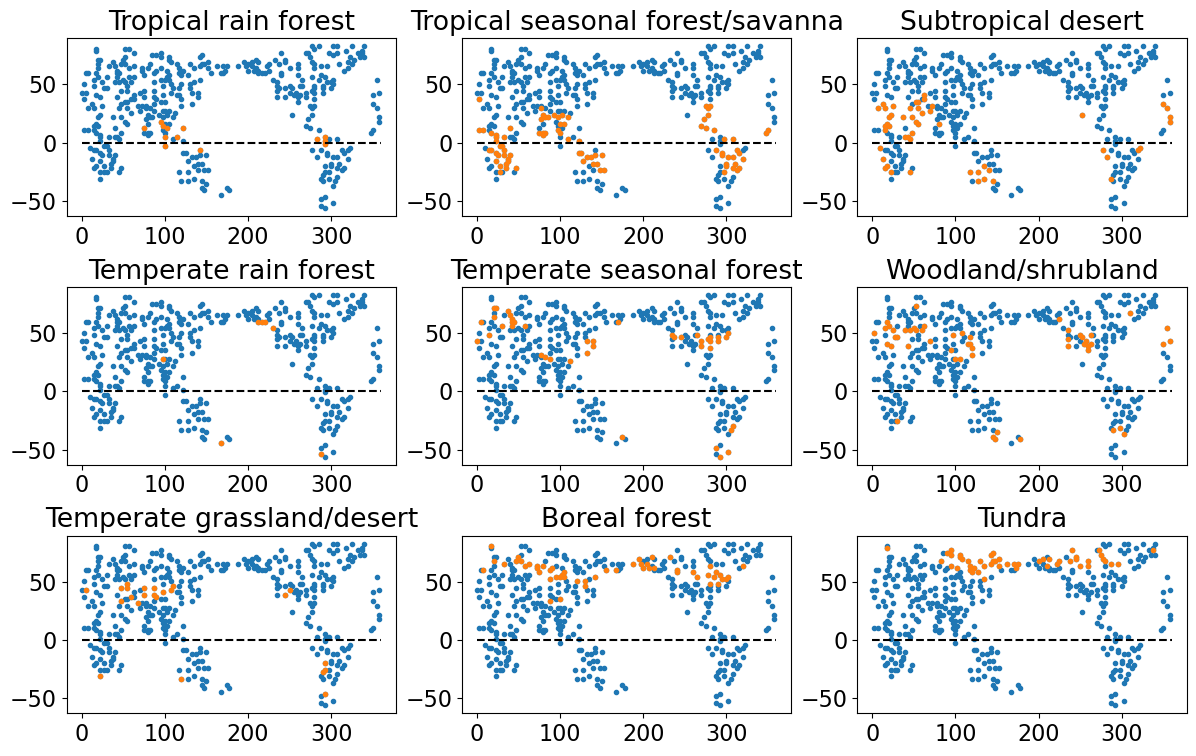

In [24]:
plt.figure(num=None, figsize=(14, 9), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.2, hspace=0.4)
plt.rcParams.update({'font.size': 16})

lats=ds.grid1d_lat
lons=ds.grid1d_lon
for bb in range(1,10,1):
    plt.subplot(3,3,bb)
    plt.plot(lons,lats,'.')
    ix=whit.biome==bb
    plt.plot(lons[ix],lats[ix],'.')
    plt.plot([0,360],[0,0],'--',c='k')
    plt.title(whit.biome_name[bb].values);
plt.savefig('../figs/lai_exploration/biome_map.png',dpi=100)

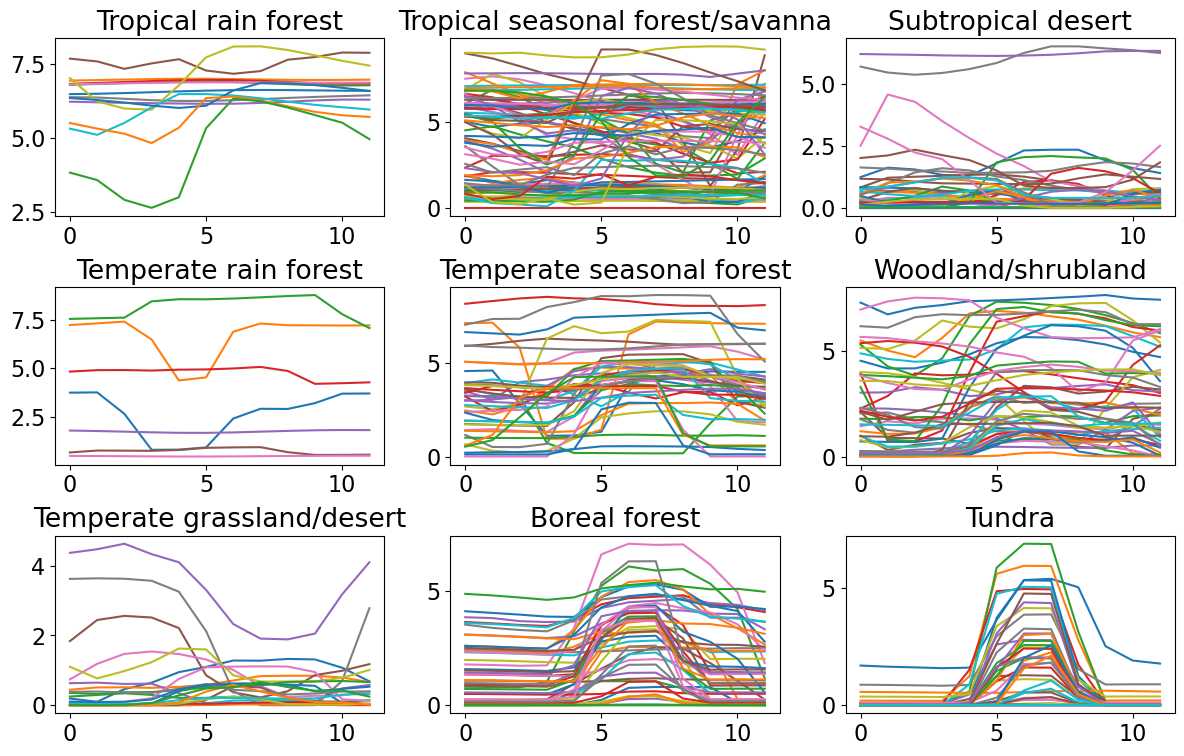

In [25]:
plt.figure(num=None, figsize=(14, 9), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.2, hspace=0.4)
plt.rcParams.update({'font.size': 16})

for bb in range(1,10,1):
    ix=whit.biome==bb
    xb = ds.TLAI[:,:,ix]
    x = xb.isel(ens=0).groupby('time.month').mean().compute()
    plt.subplot(3,3,bb)
    plt.plot(x)
    plt.title(whit.biome_name[bb].values);
plt.savefig('../figs/lai_exploration/biome_seasonal_cycle_2005-2014_CLMdefault.png',dpi=100)

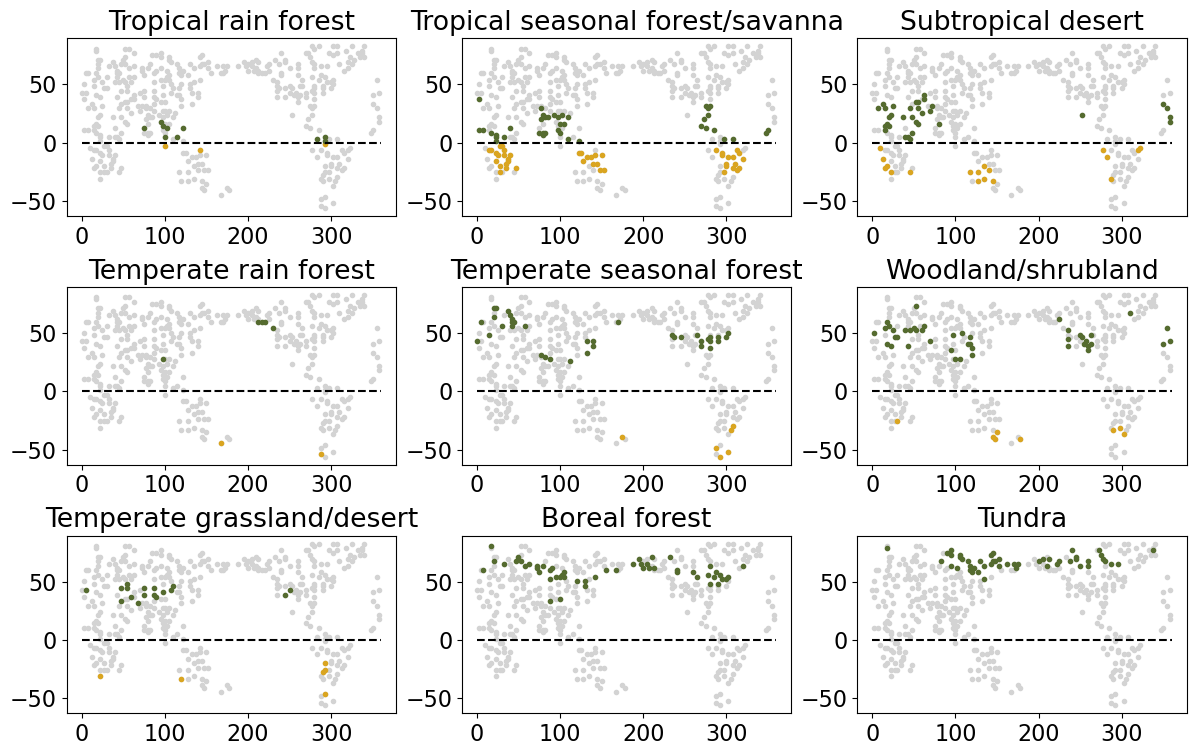

In [55]:
plt.figure(num=None, figsize=(14, 9), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.2, hspace=0.4)
plt.rcParams.update({'font.size': 16})

lats=ds.grid1d_lat
lons=ds.grid1d_lon

slats = lats[lats<0]
slons = lons[lats<0]

nlats = lats[lats>0]
nlons = lons[lats>0]

for bb in range(1,10,1):
    plt.subplot(3,3,bb)
    plt.plot(lons,lats,'.',c='lightgrey')
    ix=whit.biome==bb
    ixs = ix[lats<0]
    ixn = ix[lats>0]
    plt.plot(slons[ixs],slats[ixs],'.',c='goldenrod')
    plt.plot(nlons[ixn],nlats[ixn],'.',c='darkolivegreen')
    plt.plot([0,360],[0,0],'--',c='k')
    plt.title(whit.biome_name[bb].values);


In [58]:
plt.figure(num=None, figsize=(14, 9), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.2, hspace=0.4)
plt.rcParams.update({'font.size': 16})

for bb in range(4,8,1):
    plt.subplot(3,3,bb)
    ix=whit.biome==bb
    
    ixs = ix[slats<0]
    xbs = ds.TLAI[:,:,ixs]
    xs = xbs.isel(ens=0).groupby('time.month').mean().compute()
    
    ixn = ix[lats>0]
    xbn = ds.TLAI[:,:,ixn]
    xn = xbn.isel(ens=0).groupby('time.month').mean().compute()
    
    plt.plot(xs,c='goldenrod')
    plt.plot(xn,c='darkolivegreen')

    plt.title(whit.biome_name[bb].values);



ValueError: the first argument to .isel must be a dictionary

<Figure size 1400x900 with 0 Axes>

LAI and climate relationships

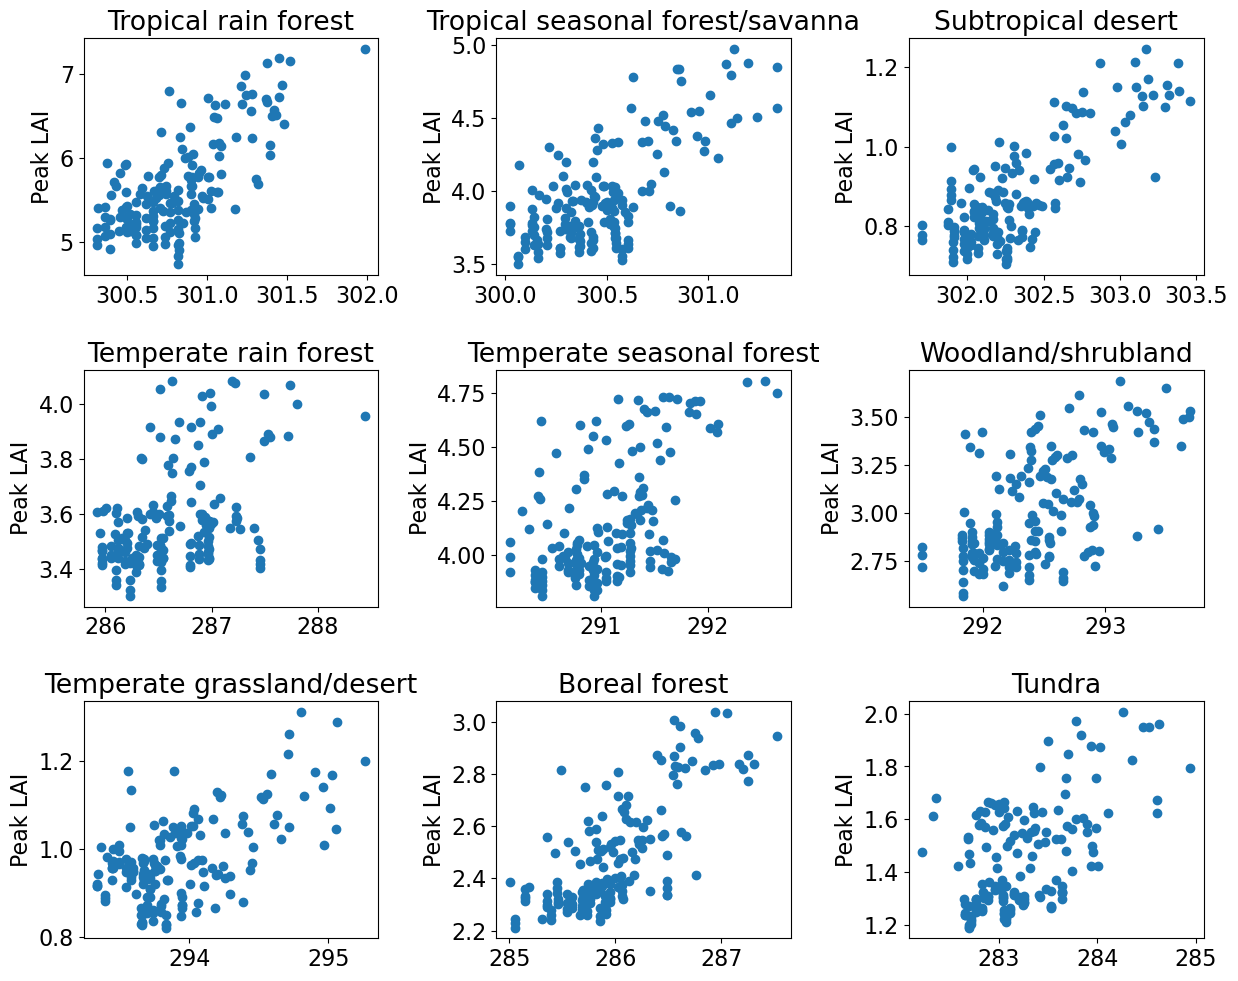

In [49]:
plt.figure(num=None, figsize=(14, 12), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.4, hspace=0.4)
plt.rcParams.update({'font.size': 16})

for bb in range(1,10,1):
    ix=whit.biome==bb
    ds_lai = ds.TLAI[0,:,ix].groupby('time.year').max().compute() # CLM default at one grid cell
    ds_ta = ds.TBOT[0,:,ix].groupby('time.year').max().compute()
    plt.subplot(3,3,bb)
    plt.scatter(np.mean(ds_ta,axis=1),np.mean(ds_lai,axis=1))
    plt.title(whit.biome_name[bb].values);
    plt.ylabel('Peak LAI')
    plt.xlabel('annual max TA')
    
plt.savefig('../figs/lai_exploration/biome_maxTA_annPeakLAI_1850-2014.png',dpi=300)

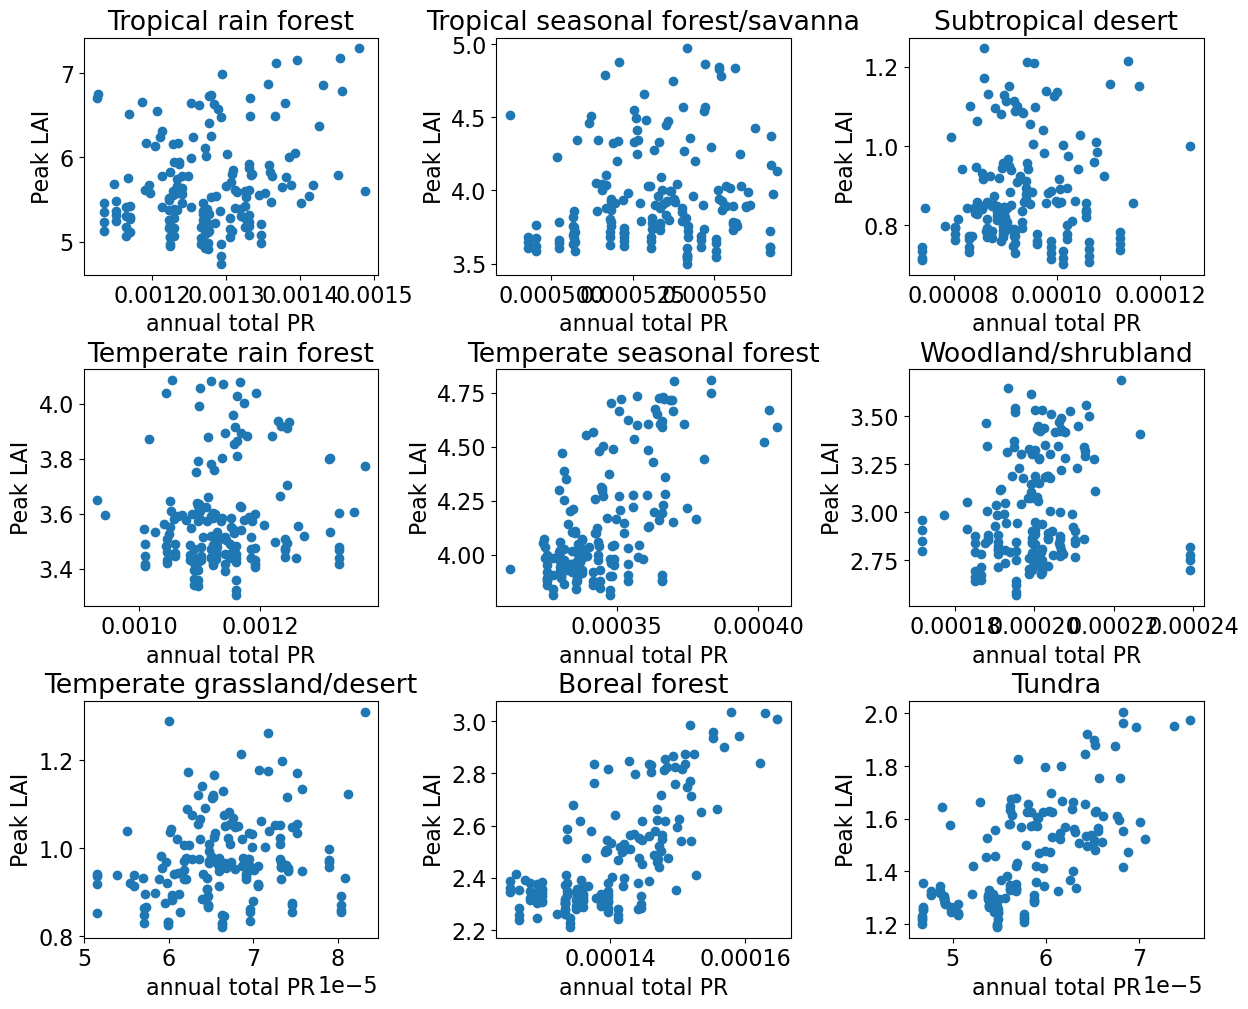

In [50]:
plt.figure(num=None, figsize=(14, 12), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9, wspace=0.4, hspace=0.4)
plt.rcParams.update({'font.size': 16})

for bb in range(1,10,1):
    ix=whit.biome==bb
    ds_lai = ds.TLAI[0,:,ix].groupby('time.year').max().compute() # CLM default at one grid cell
    ds_pr = ds.RAIN[0,:,ix].groupby('time.year').sum().compute()
    plt.subplot(3,3,bb)
    plt.scatter(np.mean(ds_pr,axis=1),np.mean(ds_lai,axis=1))
    plt.title(whit.biome_name[bb].values);
    plt.ylabel('Peak LAI')
    plt.xlabel('annual total PR')
    
plt.savefig('../figs/lai_exploration/biome_anntotPR_annPeakLAI_1850-2014.png',dpi=300)

In [52]:
for v in ds.data_vars:
    if 'long_name' in ds[v].attrs:
        if 'rain' in ds[v].attrs['long_name']:
            print(v,ds[v].attrs['long_name'])

RAIN atmospheric rain, after rain/snow repartitioning based on temperature
